In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('../../../module/')

from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
import csv
from util import *
import gym2
from rl2.agents import selfDDPGAgent, selfDDPGAgent2
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
env = gym2.make('Linear-v0')

In [3]:
def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

def branch_actor(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input) # 実質的なinput layer
    
    x1 = Dense(8, activation="relu")(x)
    x1 = Dense(8, activation="relu")(x1)
    x1 = Dense(1, activation="multiple_tanh")(x1) # action signal
    
    x2 = Dense(8, activation="relu")(x)
    x2 = Dense(8, activation="relu")(x2)
    x2 = Dense(1, activation="tau_output")(x2) # tau
    
    output = concatenate([x1, x2])
    actor = Model(inputs=action_input, outputs=output)
    return actor


def agent2(a_shape, s_shape):
    actor = branch_actor(a_shape, s_shape)
    critic, critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = selfDDPGAgent2(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        mb_noise=False,
        coef_u=.01,
        coef_tau=.001,
        action_clipper=[-10., 10.],
        tau_clipper=[0.001, 1.],
        params_logging=False,
        gradient_logging=False,
        batch_size=128,
    )
    return agent

In [4]:
#learning   
l = .1
step = 1000000  # num of interval
episode_step = step
a = agent2((2,), (2,))
actor_optimizer, critic_optimizer = Adam(lr=100., clipnorm=1.), Adam(lr=0.001, clipnorm=1.) # actorの方は何でもいい
optimizer = [actor_optimizer, critic_optimizer]
a.compile(optimizer=optimizer, metrics=["mse"], action_lr=0.0001, tau_lr=0.001)

In [6]:
a.load_weights('../saved_agent/linear_init.h5')
out = a.fit(env, l=l, nb_steps=step, visualize=0, verbose=1, nb_max_episode_steps=episode_step, episode_time=5.)

Training for 1000000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 91s 9ms/step - reward: -0.0056
28 episodes - episode_reward: -1.972 [-2.936, 0.438] - loss: 0.016 - mean_squared_error: 0.032 - mean_q: 0.942

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 93s 9ms/step - reward: -0.0080
25 episodes - episode_reward: -3.081 [-3.578, -2.391] - loss: 0.010 - mean_squared_error: 0.020 - mean_q: 1.113

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 101s 10ms/step - reward: -0.0087
27 episodes - episode_reward: -3.304 [-4.159, -0.794] - loss: 0.006 - mean_squared_error: 0.012 - mean_q: 1.094

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 97s 10ms/step - reward: -0.0084
23 episodes - episode_reward: -3.609 [-4.205, -2.572] - loss: 0.002 - mean_squared_error: 0.005 - mean_q: 0.975

Interval 5 (40000 steps performed)
10000/10000 [===================

10000/10000 [==============================] - 105s 11ms/step - reward: 0.0108
311 episodes - episode_reward: 0.347 [0.127, 0.448] - loss: 0.001 - mean_squared_error: 0.003 - mean_q: 0.331

Interval 38 (370000 steps performed)
10000/10000 [==============================] - 107s 11ms/step - reward: 0.0125
368 episodes - episode_reward: 0.339 [0.175, 0.450] - loss: 0.002 - mean_squared_error: 0.004 - mean_q: 0.355

Interval 39 (380000 steps performed)
10000/10000 [==============================] - 106s 11ms/step - reward: 0.0118
348 episodes - episode_reward: 0.340 [-2.282, 0.450] - loss: 0.002 - mean_squared_error: 0.004 - mean_q: 0.372

Interval 40 (390000 steps performed)
10000/10000 [==============================] - 108s 11ms/step - reward: 0.0131
399 episodes - episode_reward: 0.328 [0.117, 0.441] - loss: 0.002 - mean_squared_error: 0.005 - mean_q: 0.391

Interval 41 (400000 steps performed)
10000/10000 [==============================] - 105s 10ms/step - reward: 0.0124
380 episodes

10000/10000 [==============================] - 115s 11ms/step - reward: -0.0017
398 episodes - episode_reward: -0.042 [-0.898, 0.408] - loss: 0.002 - mean_squared_error: 0.005 - mean_q: 0.426

Interval 74 (730000 steps performed)
10000/10000 [==============================] - 121s 12ms/step - reward: -0.0023
709 episodes - episode_reward: -0.033 [-1.175, 0.424] - loss: 0.003 - mean_squared_error: 0.006 - mean_q: 0.434

Interval 75 (740000 steps performed)
10000/10000 [==============================] - 108s 11ms/step - reward: 0.0029
78 episodes - episode_reward: 0.369 [0.175, 0.453] - loss: 0.003 - mean_squared_error: 0.005 - mean_q: 0.399

Interval 76 (750000 steps performed)
10000/10000 [==============================] - 109s 11ms/step - reward: 8.4765e-04
22 episodes - episode_reward: 0.391 [0.354, 0.412] - loss: 0.002 - mean_squared_error: 0.004 - mean_q: 0.381

Interval 77 (760000 steps performed)
10000/10000 [==============================] - 110s 11ms/step - reward: 8.2484e-04
2

In [7]:
a.training = False

env.reset()
initial_state = np.array([3., 3.])
env.set_state(initial_state)

states = [initial_state]
detail_states = [initial_state]

time_limit = 10
time_log = [0.]
taus = []
acc_time = 0
episode_reward = 0
i = 0
detail_time_log = [0.]

action_log = []


while True:
    reward = 0
    x = env.state
    a_agent, tau = a.forward(x)
    tau = np.clip(tau, .01, 1.)
    taus.append(tau)
    acc_time += tau
    time_log.append(acc_time)
    dt = 0.01
    action_repetition = int(tau * 100)  # minimum natural number which makes `dt` smaller than 0.005
    # print(tau, dt, action_repetition)
    for p in range(action_repetition):
        action_log.append(a_agent)
        _,r,_,_ = env.step(np.array([a_agent]), dt, tau)
        reward += r
        detail_states.append(env.state)
        i += 1
        detail_time_log.append(i * dt)
    reward *= dt
    reward += - 0.01 * a_agent**2 + l * tau
    episode_reward += reward
    states.append(env.state)
    if acc_time > time_limit:
        break
action_log.append(a.forward(env.state)[0])
states = np.array(states)
detail_states = np.array(detail_states)

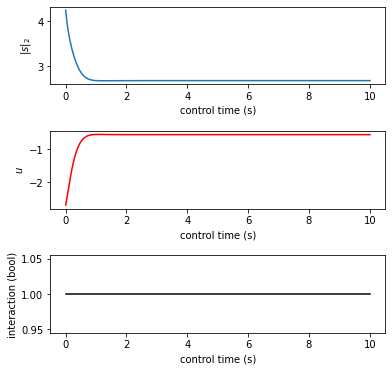

In [8]:
plt.figure(figsize=(6,6))
plt.subplots_adjust(hspace=0.6)

# state
plt.subplot(3,1,1)
plt.xlabel('control time (s)')
plt.ylabel('$\|s\|_2$')
plt.plot(detail_time_log, np.linalg.norm(detail_states, axis=1))
#plt.scatter(time_log, states[:,0], marker='.')

# action
plt.subplot(3,1,2)
plt.xlabel('control time (s)')
plt.ylabel('$u$')
plt.plot(detail_time_log, action_log, color='red')

# communication
indices = []
for t in np.round(time_log, decimals=2):
    if t in np.round(detail_time_log, decimals=2):
        indices.append(np.where(t == np.round(detail_time_log, decimals=2))[0][0])
com = np.zeros_like(detail_time_log)
com[indices] = 1
plt.subplot(3,1,3)
plt.xlabel('control time (s)')
plt.ylabel('interaction (bool)')
plt.plot(detail_time_log, com, color='black')

plt.show()

In [9]:
a.save_weights('../saved_agent/small_noise0.h5')